## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [64]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [65]:
!gdown --id 1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K

Downloading...
From: https://drive.google.com/uc?id=1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K
To: /content/complaints-2021-05-14_08_16.json
83.4MB [00:00, 199MB/s]


In [66]:
# Opening JSON file 
f = open('/content/complaints-2021-05-14_08_16.json')# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)


## Data preparation

In [67]:
# Inspect the dataframe to understand the given data.
df.head(10)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [68]:
#print the column names
for col in df.columns:
  print(col)


_index
_type
_id
_score
_source.tags
_source.zip_code
_source.complaint_id
_source.issue
_source.date_received
_source.state
_source.consumer_disputed
_source.product
_source.company_response
_source.company
_source.submitted_via
_source.date_sent_to_company
_source.company_public_response
_source.sub_product
_source.timely
_source.complaint_what_happened
_source.sub_issue
_source.consumer_consent_provided


In [69]:
df.shape

(78313, 22)

In [70]:
#Assign new column names
df.rename(columns ={'_index': 'index', '_type': 'type', '_id': 'id', '_score': 'score', '_source.tags': 'source_tags', 
                    '_source.zip_code': 'source_zip_code', '_source.complaint_id': 'source_complaint_id',
                    '_source.complaint_id': 'source_complaint_id', '_source.issue': 'source_issue',
                    '_source.date_received': 'source_date_received', '_source.state': 'source_state',
                    '_source.consumer_disputed': 'source_consumer_disputed', '_source.product': 'source_product',
                    '_source.company_response': 'source_company_response', '_source.company': 'source_company',
                    '_source.submitted_via': 'source_submitted_via', '_source.date_sent_to_company': 'source_date_sent_to_company',
                    '_source.company_public_response': 'source_company_public_response', '_source.sub_product': 'source_sub_product',
                    '_source.timely': 'source_timely', '_source.complaint_what_happened': 'source_complaint_what_happened',
                    '_source.sub_issue': 'source_sub_issue', '_source.consumer_consent_provided': 'source_consumer_consent_provided'}, inplace = True)

In [71]:
#Assign nan in place of blanks in the complaints column
df[df['source_complaint_what_happened']== ''] = np.nan 

In [72]:
#Remove all rows where complaints column is nan
df = df[df['source_complaint_what_happened'].notnull()]

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [73]:
# function to clean the text and remove all the unnecessary elements.
def clean_text(text):
    text = text.lower() # Converting to lower case
    text = re.sub("[\[].*?[\]]", "", text) # removing text in Square brackets
    text = re.sub(r'[^\w\s]', '', text)  # removing punctuation
    text = re.sub("\S*\d\S*", "", text).strip()  # remove words containing numbers
    return text

df.source_complaint_what_happened = pd.DataFrame(df.source_complaint_what_happened.apply(lambda x: clean_text(x)))

In [74]:
from nltk.stem import WordNetLemmatizer # we can also use lemmatizer instead of stemming
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')

#function to Lemmatize the texts
def lemmatizer(text):  
    text=text.split(" ")      
    sent = [wordnet_lemmatizer.lemmatize(word) for word in text if not word in set(stopwords.words('english'))]
    return " ".join(sent)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [75]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df['lemmatized_complaints'] =  df.source_complaint_what_happened.apply(lambda x: lemmatizer(x))
df_clean=df[['lemmatized_complaints','source_complaint_what_happened']]

In [76]:
df_clean.head(5)

,lemmatized_complaints,source_complaint_what_happened
1,good morning name xxxx xxxx appreciate could h...,good morning my name is xxxx xxxx and i apprec...
2,upgraded xxxx xxxx card told agent upgrade an...,i upgraded my xxxx xxxx card in and was told ...
10,chase card reported however fraudulent applic...,chase card was reported on however fraudulent...
11,trying book xxxx xxxx ticket came across of...,on while trying to book a xxxx xxxx ticket ...
14,grand son give check deposit chase account fu...,my grand son give me check for i deposit it i...


In [77]:
#Write your function to extract the POS tags 
model = spacy.load("en_core_web_sm")
def getPOSTagslist(sentence):
 #print(sentence) 
 postaglist=model(sentence)
 #print(postaglist)
 sent = [token.text for token in postaglist if(token.tag_=='NN')] # Only Noun tags
 #print(sent)
 return " ".join(sent)

In [78]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean['complaint_POS_removed']=df_clean.lemmatized_complaints.apply(lambda x: getPOSTagslist(x))
df_clean

,lemmatized_complaints,source_complaint_what_happened,complaint_POS_removed
1,good morning name xxxx xxxx appreciate could h...,good morning my name is xxxx xxxx and i apprec...,morning name bank cardmember service chase deb...
2,upgraded xxxx xxxx card told agent upgrade an...,i upgraded my xxxx xxxx card in and was told ...,card agent anniversary date agent information ...
10,chase card reported however fraudulent applic...,chase card was reported on however fraudulent...,card application identity consent service cred...
11,trying book xxxx xxxx ticket came across of...,on while trying to book a xxxx xxxx ticket ...,book ticket offer ticket reward card informati...
14,grand son give check deposit chase account fu...,my grand son give me check for i deposit it i...,son check account money son money pay son time...
...,...,...,...
78303,chase card customer well decade offered multip...,after being a chase card customer for well ove...,card customer decade solicitation credit card ...
78309,wednesday xxxxxxxx called chas xxxx xxxx visa ...,on wednesday xxxxxxxx i called chas my xxxx xx...,card provider claim purchase protection benefi...
78310,familiar xxxx pay understand great risk provid...,i am not familiar with xxxx pay and did not un...,risk consumer year trust mobile banking deal m...
78311,flawless credit yr ive chase credit card cha...,i have had flawless credit for yrs ive had ch...,credit credit card chase freedom problem balan...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




(array([9.543e+03, 6.289e+03, 2.621e+03, 1.244e+03, 7.080e+02, 2.490e+02,
        1.370e+02, 7.600e+01, 4.700e+01, 4.100e+01, 3.200e+01, 1.500e+01,
        9.000e+00, 1.200e+01, 7.000e+00, 8.000e+00, 4.000e+00, 4.000e+00,
        3.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 4.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([    0.  ,   216.04,   432.08,   648.12,   864.16,  1080.2 ,
         1296.24,  1512.28,  1728.32,  1944.36,  2160.4 ,  2376.44,
         2592.48,  2808.52,  3024.56,  3240.6 ,  3456.64,  3672.68,
         3888.72,  4104.76,  4320.8 ,  4536.84,  4752.88,  4968.92,
         5184.96,  5401.  ,  5617.04,  5833.08,  6049.12,  6265.16,
         6481.2 ,  6697.24,  6913.28

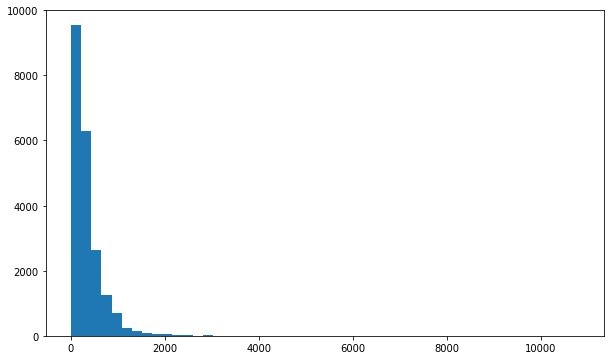

In [79]:
# Write your code here to visualise the data according to the 'Complaint' character length
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 50)

#### Find the top 40 words by frequency among all the articles after processing the text.

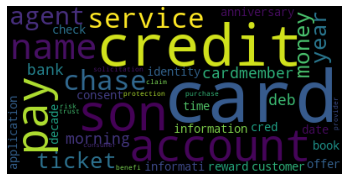

In [80]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
!pip install wordcloud
from wordcloud import WordCloud
stoplist = set(stopwords.words("english"))
wordcloud = WordCloud(stopwords=stoplist,max_words=40).generate(str(df_clean.complaint_POS_removed))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [81]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
#df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('-NOUN-', '')


In [82]:
df_clean

,lemmatized_complaints,source_complaint_what_happened,complaint_POS_removed,Complaint_clean
1,good morning name xxxx xxxx appreciate could h...,good morning my name is xxxx xxxx and i apprec...,morning name bank cardmember service chase deb...,morning name bank cardmember service chase deb...
2,upgraded xxxx xxxx card told agent upgrade an...,i upgraded my xxxx xxxx card in and was told ...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card reported however fraudulent applic...,chase card was reported on however fraudulent...,card application identity consent service cred...,card application identity consent service cred...
11,trying book xxxx xxxx ticket came across of...,on while trying to book a xxxx xxxx ticket ...,book ticket offer ticket reward card informati...,book ticket offer ticket reward card informati...
14,grand son give check deposit chase account fu...,my grand son give me check for i deposit it i...,son check account money son money pay son time...,son check account money son money pay son time...
...,...,...,...,...
78303,chase card customer well decade offered multip...,after being a chase card customer for well ove...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,wednesday xxxxxxxx called chas xxxx xxxx visa ...,on wednesday xxxxxxxx i called chas my xxxx xx...,card provider claim purchase protection benefi...,card provider claim purchase protection benefi...
78310,familiar xxxx pay understand great risk provid...,i am not familiar with xxxx pay and did not un...,risk consumer year trust mobile banking deal m...,risk consumer year trust mobile banking deal m...
78311,flawless credit yr ive chase credit card cha...,i have had flawless credit for yrs ive had ch...,credit credit card chase freedom problem balan...,credit credit card chase freedom problem balan...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [83]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_unigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    print("--1",sum_words)
    for word, idx in vec.vocabulary_.items():
        print(word)
        print(idx)
        break
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #print("-31",words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n] # Return Top 'n' words
common_words = get_top_n_unigram(df_clean.Complaint_clean, 30)

--1 [[ 1  1  3 ...  6 23  1]]
morning
6527


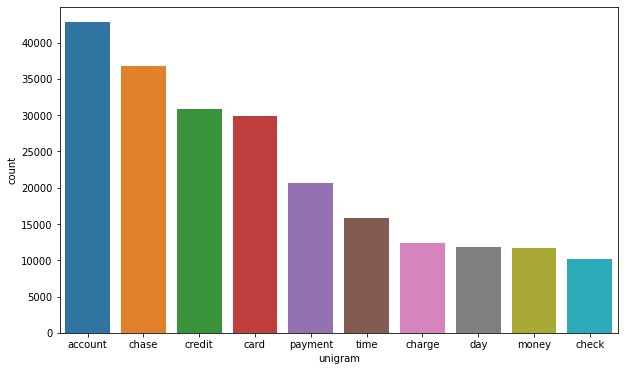

In [84]:
#Print the top 10 words in the unigram frequency

df3 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
df3=df3.iloc[:10,:]
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(10, 6))
# drawing the plot
sns.barplot(x=df3['unigram'], y=df3['count'], ax=ax)
plt.show()


In [85]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    print("--1",sum_words)
    for word, idx in vec.vocabulary_.items():
        print(word)
        print(idx)
        break
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #print("-31",words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df_clean.Complaint_clean, 10)

--1 [[1 1 1 ... 1 1 1]]
morning bank
143113


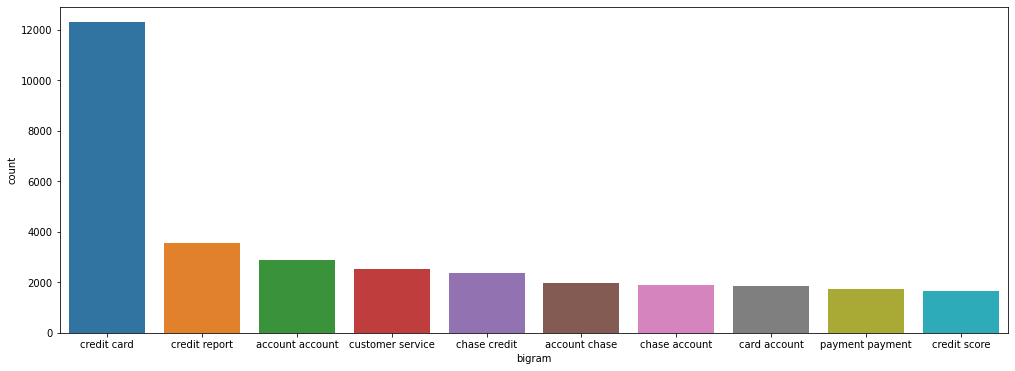

In [86]:
#Print the top 10 words in the bigram frequency
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
df3=df3.iloc[:10,:]
fig, ax = plt.subplots(figsize=(17, 6))
# drawing the plot
sns.barplot(x=df3['bigram'], y=df3['count'], ax=ax)

In [87]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    print("--1",sum_words)
    for word, idx in vec.vocabulary_.items():
        print(word)
        print(idx)
        break
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #print("-31",words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df_clean.Complaint_clean, 30)

--1 [[1 1 1 ... 1 1 1]]
morning bank cardmember
407890


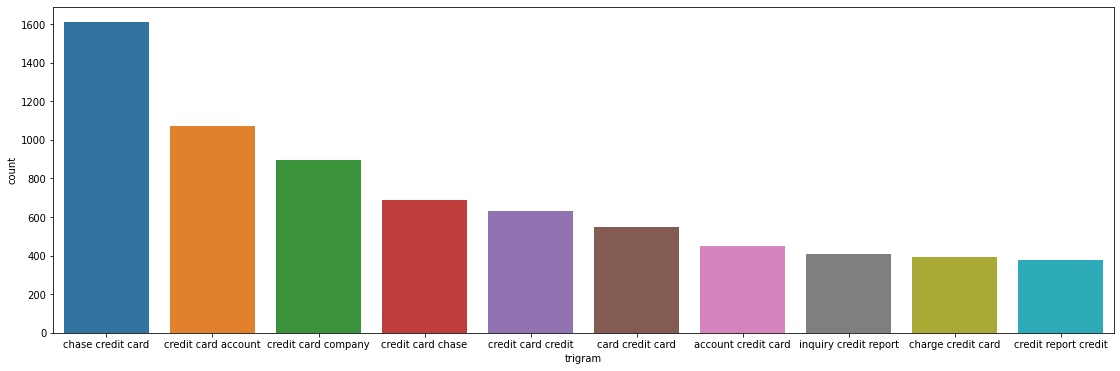

In [88]:
#Print the top 10 words in the trigram frequency
df_unigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
df3 = df_unigram.iloc[:10,:]
fig, ax = plt.subplots(figsize=(19, 6))
# drawing the plot
sns.barplot(x=df3['trigram'], y=df3['count'], ax=ax)


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [89]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [90]:
#All masked texts has been removed
df_clean

,lemmatized_complaints,source_complaint_what_happened,complaint_POS_removed,Complaint_clean
1,good morning name xxxx xxxx appreciate could h...,good morning my name is xxxx xxxx and i apprec...,morning name bank cardmember service chase deb...,morning name bank cardmember service chase deb...
2,upgraded xxxx xxxx card told agent upgrade an...,i upgraded my xxxx xxxx card in and was told ...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card reported however fraudulent applic...,chase card was reported on however fraudulent...,card application identity consent service cred...,card application identity consent service cred...
11,trying book xxxx xxxx ticket came across of...,on while trying to book a xxxx xxxx ticket ...,book ticket offer ticket reward card informati...,book ticket offer ticket reward card informati...
14,grand son give check deposit chase account fu...,my grand son give me check for i deposit it i...,son check account money son money pay son time...,son check account money son money pay son time...
...,...,...,...,...
78303,chase card customer well decade offered multip...,after being a chase card customer for well ove...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,wednesday xxxxxxxx called chas xxxx xxxx visa ...,on wednesday xxxxxxxx i called chas my xxxx xx...,card provider claim purchase protection benefi...,card provider claim purchase protection benefi...
78310,familiar xxxx pay understand great risk provid...,i am not familiar with xxxx pay and did not un...,risk consumer year trust mobile banking deal m...,risk consumer year trust mobile banking deal m...
78311,flawless credit yr ive chase credit card cha...,i have had flawless credit for yrs ive had ch...,credit credit card chase freedom problem balan...,credit credit card chase freedom problem balan...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [91]:
#Write your code here to initialise the TfidfVectorizer 
vectorizer = TfidfVectorizer(stop_words='english',max_df=0.95, min_df=2)



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [92]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf = vectorizer.fit_transform(df_clean.Complaint_clean) 
pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())

,ab,abandonment,abatement,abet,abhorrent,abide,abiding,ability,absence,absolute,absolve,absurdity,abundance,abuse,abusing,abusive,acccount,acceleration,accent,accept,acceptance,access,accessibility,accessing,accessory,accident,accommodation,accomplice,accomplish,accont,accord,accordance,according,accouint,accound,account,accountability,accountant,accountbalance,accountchase,...,working,workingclass,workmanship,workout,workplace,worksheet,workshop,world,worm,worry,worth,worthiness,worthlessness,woudl,wouldbe,wound,wrap,wreck,wrist,writ,write,writeoff,writer,writing,wrong,wrongdoing,wwwchasecom,yard,yea,year,yelling,yelp,yesterday,yield,yoga,yr,ytd,zip,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.085924,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.073746,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.124485,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069382,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058646,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.092593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.039363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028487,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.044977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.12842,0.0,0.

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [93]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [94]:
from sklearn import decomposition
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out
#keep the random_state =40
# Trail and Error
def nooftopics(ntopics):
  nmf_model = decomposition.NMF(n_components=ntopics,random_state=40)#write your code here
  nmf_model.fit(tfidf)
  len(vectorizer.get_feature_names())
  W = nmf_model.fit_transform(tfidf)   # Document-topic matrix
  H = nmf_model.components_       # Topic-term matrix
  words = np.array(vectorizer.get_feature_names())
  topic_words = pd.DataFrame(np.zeros((ntopics, 15)), index=[f'Topic {i + 1}' for i in range(ntopics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
  for i in range(ntopics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]
  return topic_words  


In [95]:
# Trail with 4 Topics
topword=nooftopics(4)
topword

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,money,bank,fund,deposit,chase,branch,day,number,business,transfer,customer,balance,transaction
Topic 2,credit,card,report,inquiry,account,chase,score,company,balance,application,limit,debt,information,year,reporting
Topic 3,payment,loan,mortgage,chase,month,time,modification,year,balance,home,statement,rate,pay,fee,property
Topic 4,charge,card,chase,transaction,dispute,merchant,fee,claim,fraud,purchase,time,email,service,refund,phone


Inference is **Topic1** has words about the account, bank, fund, deposit, balance mostly talks about the service.
**Topic2** has words like credit card, score, balance mostly talks about credit card
**Topic3** has words like loan mortgage, rate, property talks about loan
**Topic4** has workds like fraud, dispute, chase talks about fraud

In [96]:
# Trail with 5 Topics
topword=nooftopics(5)
topword

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,money,bank,fund,deposit,chase,branch,day,number,business,transfer,customer,transaction,time
Topic 2,credit,card,report,inquiry,chase,account,score,company,limit,application,debt,year,balance,information,letter
Topic 3,payment,balance,month,fee,statement,day,pay,date,time,chase,auto,credit,error,car,year
Topic 4,charge,card,transaction,chase,dispute,fee,merchant,claim,fraud,purchase,service,email,time,refund,phone
Topic 5,loan,mortgage,modification,chase,home,year,property,rate,time,document,letter,sale,debt,information,foreclosure


Inference is **Topic1** has words about the account, bank, fund, deposit, balance mostly talks about the service.
**Topic2** has words like credit card, score, balance mostly talks about credit card
**Topic3** has words like loan payment, balance, statement talks about enquiry
**Topic4** has workds like fraud, dispute, chase talks about fraud
**Topic5** has workds like loan, mortgage,home talks about loan



In [97]:
# Trail with 6 Topics
topword=nooftopics(6)
topword

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,money,chase,bank,branch,number,fund,transfer,balance,deposit,information,reason,business,day,checking
Topic 2,credit,card,report,inquiry,chase,score,company,limit,application,debt,year,balance,information,reporting,letter
Topic 3,payment,balance,month,fee,statement,day,pay,date,time,auto,chase,credit,error,car,year
Topic 4,charge,card,transaction,chase,dispute,fee,merchant,claim,fraud,purchase,service,time,email,refund,phone
Topic 5,loan,mortgage,modification,chase,home,year,property,rate,time,document,letter,sale,debt,information,foreclosure
Topic 6,check,money,fund,bank,deposit,day,branch,cash,chase,claim,cashier,hold,business,customer,person


Inference is **Topic1** has words about the account, bank, fund, deposit, balance mostly talks about the service.
**Topic2** has words like credit card, score, balance mostly talks about credit card
**Topic3** has words like loan payment, balance, statement talks about enquiry
**Topic4** has workds like fraud, dispute, chase talks about fraud
**Topic5** has workds like loan, mortgage,home talks about loan
**Topic6** has workds like bank, deposit, check,fund talks about service

In [98]:
# Trail with 7 Topics
topword=nooftopics(7)
topword

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,money,chase,bank,branch,number,fund,transfer,balance,deposit,information,reason,transaction,business,day
Topic 2,card,credit,chase,balance,purchase,point,year,limit,month,offer,score,application,time,customer,reason
Topic 3,payment,balance,month,fee,statement,day,pay,date,time,credit,auto,chase,error,car,history
Topic 4,charge,transaction,dispute,chase,merchant,claim,fraud,fee,purchase,email,refund,company,time,day,service
Topic 5,loan,mortgage,chase,modification,home,year,property,rate,time,document,letter,sale,foreclosure,process,debt
Topic 6,check,money,fund,bank,deposit,day,branch,cash,chase,claim,cashier,hold,business,customer,time
Topic 7,credit,report,inquiry,company,information,debt,reporting,score,bureau,identity,theft,letter,file,creditor,application


Inference is **Topic1** has words about the account, bank, fund, deposit, balance mostly talks about the service.
**Topic2** has words like credit card, score, balance mostly talks about credit card
**Topic3** has words like loan payment, balance, statement talks about enquiry
**Topic4** has workds like fraud, dispute, chase talks about fraud
**Topic5** has workds like loan, mortgage,home talks about loan
**Topic6** has workds like bank, deposit, check,fund talks about service
**Topic7** has workds like inquiry, information, report talks about fraud/enquiry

In [99]:
# Trail with 8 Topics
topword=nooftopics(8)
topword

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,money,chase,bank,branch,number,fund,information,deposit,reason,transfer,business,checking,transaction,day
Topic 2,card,credit,chase,purchase,point,balance,limit,year,month,score,application,offer,time,reason,customer
Topic 3,payment,month,statement,balance,day,time,date,pay,credit,auto,chase,error,car,history,plan
Topic 4,charge,dispute,transaction,chase,merchant,claim,fraud,email,company,purchase,refund,day,phone,time,service
Topic 5,loan,mortgage,modification,chase,home,year,property,rate,time,document,letter,sale,foreclosure,process,debt
Topic 6,check,money,fund,bank,deposit,day,branch,cash,chase,claim,cashier,hold,business,customer,person
Topic 7,credit,report,inquiry,company,debt,information,reporting,score,bureau,identity,theft,file,letter,creditor,date
Topic 8,fee,balance,overdraft,transfer,transaction,statement,month,year,charge,pay,fund,customer,time,dollar,day


Inference is **Topic1** has words about the account, bank, fund, deposit, balance mostly talks about the service.
**Topic2** has words like credit card, score, balance mostly talks about credit card
**Topic3** has words like loan payment, balance, statement talks about enquiry
**Topic4** has workds like fraud, dispute, chase talks about fraud
**Topic5** has workds like loan, mortgage,home talks about loan
**Topic6** has workds like bank, deposit, check,fund talks about service
**Topic7** has workds like inquiry, information, report talks about fraud/enquiry
**Topic 8** has words like fee, balance, overdraft, transfer, statement talks more about the service

In [100]:
# Trail with 9 Topics
topword=nooftopics(9)
topword

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,chase,reason,checking,deposit,branch,saving,business,balance,fund,access,bank,year,information,letter
Topic 2,card,credit,chase,purchase,point,balance,limit,year,month,score,application,offer,time,customer,reason
Topic 3,payment,month,statement,balance,day,time,date,pay,credit,chase,auto,error,car,history,phone
Topic 4,charge,dispute,merchant,chase,fraud,company,statement,purchase,letter,refund,item,service,time,email,billing
Topic 5,loan,mortgage,modification,chase,home,year,property,rate,document,time,letter,sale,foreclosure,month,debt
Topic 6,check,fund,deposit,bank,day,branch,money,cash,cashier,hold,business,chase,teller,manager,week
Topic 7,credit,report,inquiry,company,information,debt,reporting,score,bureau,identity,theft,file,letter,date,consumer
Topic 8,fee,balance,overdraft,transfer,statement,month,year,transaction,pay,customer,fund,time,dollar,day,service
Topic 9,money,transaction,claim,chase,bank,number,day,phone,fraud,email,transfer,time,customer,person,information


Inference is **Topic1** has words about the account, bank, fund, deposit, balance mostly talks about the service.
**Topic2** has words like credit card, score, balance mostly talks about credit card
**Topic3** has words like loan payment, balance, statement talks about enquiry
**Topic4** has workds like fraud, dispute, chase talks about fraud
**Topic5** has workds like loan, mortgage,home talks about loan
**Topic6** has workds like bank, deposit, check,fund talks about service
**Topic7** has workds like inquiry, information, report talks about fraud/enquiry
**Topic 8** has words like fee, balance, overdraft, transfer, statement talks more about the service
**Topic 9 **has words like transaction, claim, fraud talks about the fraud

In [101]:
# Trail with 10 Topics
topword=nooftopics(10)
topword

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,chase,reason,deposit,checking,branch,saving,business,fund,access,bank,information,letter,year,number
Topic 2,card,credit,chase,point,purchase,year,limit,application,score,time,month,customer,offer,reason,service
Topic 3,payment,month,day,statement,time,pay,date,chase,auto,credit,error,car,history,phone,plan
Topic 4,charge,dispute,merchant,chase,fraud,company,statement,purchase,letter,refund,item,service,time,email,billing
Topic 5,loan,mortgage,modification,chase,home,year,property,rate,document,time,letter,sale,foreclosure,month,process
Topic 6,check,fund,deposit,bank,day,branch,money,cash,cashier,hold,business,chase,teller,manager,week
Topic 7,credit,report,inquiry,company,information,debt,reporting,score,bureau,identity,theft,file,letter,consumer,creditor
Topic 8,fee,overdraft,transaction,year,fund,time,customer,month,pay,dollar,day,service,bank,refund,deposit
Topic 9,money,transaction,claim,chase,bank,number,day,phone,fraud,email,transfer,time,person,customer,information
Topic 10,balance,transfer,statement,rate,purchase,month,date,pay,credit,limit,debt,offer,period,advance,cycle


Inference is **Topic1** has words about the account, bank, fund, deposit, balance mostly talks about the service.
**Topic2** has words like credit card, score, balance mostly talks about credit card
**Topic3** has words like loan payment, balance, statement talks about enquiry
**Topic4** has workds like fraud, dispute, chase talks about fraud
**Topic5** has workds like loan, mortgage,home talks about loan
**Topic6** has workds like bank, deposit, check,fund talks about service
**Topic7** has workds like inquiry, information, report talks about fraud/enquiry
**Topic 8** has words like fee, balance, overdraft, transfer, statement talks more about the service
**Topic 9 **has words like transaction, claim, fraud talks about the fraud
**Topic 10** has balance, transfer, credit, purchase, limit talks more credit card

In [102]:
# Trail with 11 Topics
topword=nooftopics(11)
topword

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,reason,deposit,checking,branch,saving,fund,business,bank,access,year,chase,activity,number,identity
Topic 2,card,credit,chase,year,limit,purchase,score,point,month,reason,use,application,debit,offer,reward
Topic 3,payment,month,day,statement,time,pay,date,auto,chase,credit,error,car,history,mortgage,plan
Topic 4,charge,dispute,merchant,fraud,transaction,purchase,company,statement,item,claim,investigation,billing,refund,card,month
Topic 5,loan,mortgage,modification,home,year,property,rate,chase,sale,foreclosure,document,time,month,tax,income
Topic 6,check,fund,deposit,bank,day,branch,cash,cashier,hold,business,money,manager,teller,chase,customer
Topic 7,credit,report,inquiry,company,reporting,debt,score,bureau,information,identity,theft,file,creditor,application,consumer
Topic 8,fee,overdraft,year,customer,time,fund,service,month,pay,day,refund,dollar,transaction,chase,deposit
Topic 9,money,transaction,claim,bank,fraud,transfer,fund,day,debit,person,wire,help,branch,withdrawal,investigation
Topic 10,balance,transfer,statement,rate,purchase,month,date,pay,chase,credit,limit,offer,period,debt,advance


Inference is **Topic1** has words about the account, bank, fund, deposit, balance mostly talks about the service.
**Topic2** has words like credit card, score, balance mostly talks about credit card
**Topic3** has words like loan payment, balance, statement talks about enquiry
**Topic4** has workds like fraud, dispute, chase talks about fraud
**Topic5** has workds like loan, mortgage,home talks about loan
**Topic6** has workds like bank, deposit, check,fund talks about service
**Topic7** has workds like inquiry, information, report talks about fraud/enquiry
**Topic 8** has words like fee, balance, overdraft, transfer, statement talks more about the service
**Topic 9 **has words like transaction, claim, fraud talks about the fraud
**Topic 10** has balance, transfer, credit, purchase, limit talks more credit card
**Topic 11** has words like chase, dispute, complaint talks about the fraud

**Inference is that we have 5 Topics which talks about the Services, credit card, balance enquiry, fraud and Loan remaining mostly are repeating**

In [103]:
#Print the Top15 words for each of the topics
ntopics=5
nmf_model = decomposition.NMF(n_components=ntopics,random_state=40)#write your code here
W = nmf_model.fit_transform(tfidf)   # Document-topic matrix
H = nmf_model.components_       # Topic-term matrix

words = np.array(vectorizer.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,money,bank,fund,deposit,chase,branch,day,number,business,transfer,customer,transaction,time
Topic 2,credit,card,report,inquiry,chase,account,score,company,limit,application,debt,year,balance,information,letter
Topic 3,payment,balance,month,fee,statement,day,pay,date,time,chase,auto,credit,error,car,year
Topic 4,charge,card,transaction,chase,dispute,fee,merchant,claim,fraud,purchase,service,email,time,refund,phone
Topic 5,loan,mortgage,modification,chase,home,year,property,rate,time,document,letter,sale,debt,information,foreclosure


In [104]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
colnames = ["Topic " + str(i+1) for i in range(nmf_model.n_components)]
docnames = ["Doc " + str(i+1) for i in range(len(df_clean.Complaint_clean))]
df_doc_topic = pd.DataFrame(np.round(W, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['best_topic'] = significant_topic
df_clean['Topic_No'] = significant_topic
df_doc_topic

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,best_topic
Doc 1,0.02,0.01,0.01,0.01,0.03,4
Doc 2,0.01,0.01,0.00,0.01,0.00,0
Doc 3,0.00,0.05,0.00,0.00,0.00,1
Doc 4,0.01,0.06,0.00,0.00,0.02,1
Doc 5,0.05,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...
Doc 21068,0.00,0.09,0.02,0.04,0.00,1
Doc 21069,0.01,0.01,0.00,0.04,0.01,3
Doc 21070,0.01,0.01,0.00,0.02,0.01,3
Doc 21071,0.00,0.06,0.09,0.02,0.01,2


In [105]:
df_clean

,lemmatized_complaints,source_complaint_what_happened,complaint_POS_removed,Complaint_clean,Topic_No
1,good morning name xxxx xxxx appreciate could h...,good morning my name is xxxx xxxx and i apprec...,morning name bank cardmember service chase deb...,morning name bank cardmember service chase deb...,4
2,upgraded xxxx xxxx card told agent upgrade an...,i upgraded my xxxx xxxx card in and was told ...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0
10,chase card reported however fraudulent applic...,chase card was reported on however fraudulent...,card application identity consent service cred...,card application identity consent service cred...,1
11,trying book xxxx xxxx ticket came across of...,on while trying to book a xxxx xxxx ticket ...,book ticket offer ticket reward card informati...,book ticket offer ticket reward card informati...,1
14,grand son give check deposit chase account fu...,my grand son give me check for i deposit it i...,son check account money son money pay son time...,son check account money son money pay son time...,0
...,...,...,...,...,...
78303,chase card customer well decade offered multip...,after being a chase card customer for well ove...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,1
78309,wednesday xxxxxxxx called chas xxxx xxxx visa ...,on wednesday xxxxxxxx i called chas my xxxx xx...,card provider claim purchase protection benefi...,card provider claim purchase protection benefi...,3
78310,familiar xxxx pay understand great risk provid...,i am not familiar with xxxx pay and did not un...,risk consumer year trust mobile banking deal m...,risk consumer year trust mobile banking deal m...,3
78311,flawless credit yr ive chase credit card cha...,i have had flawless credit for yrs ive had ch...,credit credit card chase freedom problem balan...,credit credit card chase freedom problem balan...,2


In [106]:
#Assign the best topic to each of the complaints in Topic Column
topic_mapping = {
    'Topic 1': 'Services',
    'Topic 2': 'Credit card ',
    'Topic 3': 'Balance Enquiry',
    'Topic 4': 'Fraud',
    'Topic 5': 'Loan'
}
N_TOPICS=5
W = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range(N_TOPICS)])
W['max_topic'] = W.apply(lambda x: topic_mapping.get(x.idxmax()), axis=1)
W[pd.notnull(W['max_topic'])].head(10)



,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,max_topic
0,0.022886,0.011177,0.006689,0.012588,0.027670,Loan
1,0.009290,0.011990,0.002437,0.010110,0.003878,Credit card
2,0.000000,0.048973,0.000000,0.001968,0.000000,Credit card
3,0.013028,0.057337,0.000083,0.002411,0.016183,Credit card
4,0.048334,0.000000,0.000653,0.002407,0.003778,Services
5,0.000000,0.037228,0.000000,0.000000,0.000000,Credit card
6,0.060240,0.001484,0.014582,0.008154,0.008808,Services
7,0.004799,0.002783,0.059297,0.005589,0.035852,Balance Enquiry
8,0.020875,0.000000,0.003289,0.068213,0.022780,Fraud
9,0.000000,0.158750,0.000000,0.000000,0.000000,Credit card


From the above we can see that our mapping giving good result, document0 having Topic 5 as Top which is Mortgage Loan

In [107]:
#Assign the best topic to each of the complaints in Topic Column
#df_clean['Topic']
topic_mapping = {
    0: 'Services',
    1: 'Credit card ',
    2: 'Balance Enquiry',
    3: 'Fraud',
    4: 'Loan'
}
df_clean['Topic'] = df_clean['Topic_No'].map(topic_mapping)

In [108]:
#Print the first 5 Complaint for each of the Topics
df_clean_check=df_clean.groupby('Topic').head(5)
df_clean_check.sort_values('Topic')


,lemmatized_complaints,source_complaint_what_happened,complaint_POS_removed,Complaint_clean,Topic_No,Topic
141,action taken company date xxxxxxxx xxxxxxxx i...,action taken by the company between the dates ...,action company date group chase claim claim pa...,action company date group chase claim claim pa...,2,Balance Enquiry
83,unknown inquire reported credit bureau xxxx ...,unknown inquire reported on my credit bureau s...,date company chase auto,date company chase auto,2,Balance Enquiry
82,recently called ask chase bank reported credit...,i recently called to ask chase bank why they r...,bureau day payment info bill balance bill amou...,bureau day payment info bill balance bill amou...,2,Balance Enquiry
20,summer month experience decline income due emp...,during the summer months i experience a declin...,summer month experience decline income employm...,summer month experience decline income employm...,2,Balance Enquiry
58,made purchase xxxxxxxx made payment xxxxxxxx...,i made a purchase of on xxxxxxxx i made payme...,purchase payment minimum payment closing date ...,purchase payment minimum payment closing date ...,2,Balance Enquiry
10,chase card reported however fraudulent applic...,chase card was reported on however fraudulent...,card application identity consent service cred...,card application identity consent service cred...,1,Credit card
11,trying book xxxx xxxx ticket came across of...,on while trying to book a xxxx xxxx ticket ...,book ticket offer ticket reward card informati...,book ticket offer ticket reward card informati...,1,Credit card
15,please remove inquiry,can you please remove inquiry,inquiry,inquiry,1,Credit card
23,chase credit card incorrectly reporting data c...,i have a chase credit card which is incorrectl...,credit card credit report company issue,credit card credit report company issue,1,Credit card
26,reached xxxx several time attempt fraudulent i...,i have reached out to xxxx several times in at...,time inquiry need call contact creditor inquir...,time inquiry need call contact creditor inquir...,1,Credit card


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [109]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   
    0: 'Bank Account services',
    1: 'Credit card or prepaid card', 
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
    }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic_No'].map(Topic_names)

In [49]:
df_clean

,lemmatized_complaints,source_complaint_what_happened,complaint_POS_removed,Complaint_clean,Topic_No,Topic
1,good morning name xxxx xxxx appreciate could h...,good morning my name is xxxx xxxx and i apprec...,morning name bank cardmember service chase deb...,morning name bank cardmember service chase deb...,4,Mortgage/Loan
2,upgraded xxxx xxxx card told agent upgrade an...,i upgraded my xxxx xxxx card in and was told ...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0,Bank Account services
10,chase card reported however fraudulent applic...,chase card was reported on however fraudulent...,card application identity consent service cred...,card application identity consent service cred...,1,Credit card or prepaid card
11,trying book xxxx xxxx ticket came across of...,on while trying to book a xxxx xxxx ticket ...,book ticket offer ticket reward card informati...,book ticket offer ticket reward card informati...,1,Credit card or prepaid card
14,grand son give check deposit chase account fu...,my grand son give me check for i deposit it i...,son check account money son money pay son time...,son check account money son money pay son time...,0,Bank Account services
...,...,...,...,...,...,...
78303,chase card customer well decade offered multip...,after being a chase card customer for well ove...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,1,Credit card or prepaid card
78309,wednesday xxxxxxxx called chas xxxx xxxx visa ...,on wednesday xxxxxxxx i called chas my xxxx xx...,card provider claim purchase protection benefi...,card provider claim purchase protection benefi...,3,Theft/Dispute Reporting
78310,familiar xxxx pay understand great risk provid...,i am not familiar with xxxx pay and did not un...,risk consumer year trust mobile banking deal m...,risk consumer year trust mobile banking deal m...,3,Theft/Dispute Reporting
78311,flawless credit yr ive chase credit card cha...,i have had flawless credit for yrs ive had ch...,credit credit card chase freedom problem balan...,credit credit card chase freedom problem balan...,2,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [110]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}
               
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [111]:
df_clean

,lemmatized_complaints,source_complaint_what_happened,complaint_POS_removed,Complaint_clean,Topic_No,Topic
1,good morning name xxxx xxxx appreciate could h...,good morning my name is xxxx xxxx and i apprec...,morning name bank cardmember service chase deb...,morning name bank cardmember service chase deb...,4,4
2,upgraded xxxx xxxx card told agent upgrade an...,i upgraded my xxxx xxxx card in and was told ...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0,0
10,chase card reported however fraudulent applic...,chase card was reported on however fraudulent...,card application identity consent service cred...,card application identity consent service cred...,1,1
11,trying book xxxx xxxx ticket came across of...,on while trying to book a xxxx xxxx ticket ...,book ticket offer ticket reward card informati...,book ticket offer ticket reward card informati...,1,1
14,grand son give check deposit chase account fu...,my grand son give me check for i deposit it i...,son check account money son money pay son time...,son check account money son money pay son time...,0,0
...,...,...,...,...,...,...
78303,chase card customer well decade offered multip...,after being a chase card customer for well ove...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,1,1
78309,wednesday xxxxxxxx called chas xxxx xxxx visa ...,on wednesday xxxxxxxx i called chas my xxxx xx...,card provider claim purchase protection benefi...,card provider claim purchase protection benefi...,3,3
78310,familiar xxxx pay understand great risk provid...,i am not familiar with xxxx pay and did not un...,risk consumer year trust mobile banking deal m...,risk consumer year trust mobile banking deal m...,3,3
78311,flawless credit yr ive chase credit card cha...,i have had flawless credit for yrs ive had ch...,credit credit card chase freedom problem balan...,credit credit card chase freedom problem balan...,2,2


In [112]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['source_complaint_what_happened','Topic']]

In [113]:
training_data

,source_complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,4
2,i upgraded my xxxx xxxx card in and was told ...,0
10,chase card was reported on however fraudulent...,1
11,on while trying to book a xxxx xxxx ticket ...,1
14,my grand son give me check for i deposit it i...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,3
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs ive had ch...,2


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [114]:
import pickle
from sklearn.feature_extraction.text import TfidfTransformer

#Write your code to get the Vector count
count_vect = CountVectorizer()
X = count_vect.fit_transform(training_data.source_complaint_what_happened)

#TRANSFORM WORD VECTOR TO TF IDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X)


y= training_data.Topic

You have to try atleast 2 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [115]:
# Write your code here to build any 3 models and evaluate them using the required metrics

# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, test_size=0.25, random_state=42)
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print("Accuracy " , accuracy_score(y_test, y_pred))
print("Confusion Matrix \n", confusion_matrix(y_test, y_pred))
print("Classification Report \n", classification_report(y_test, y_pred))




Accuracy  0.6685649202733486
Confusion Matrix 
 [[1282  101    0   25    4]
 [ 224 1017    0   79    3]
 [ 266  243   11   32   49]
 [ 347   65    0  686    1]
 [ 193  111    0    3  526]]
Classification Report 
               precision    recall  f1-score   support

           0       0.55      0.91      0.69      1412
           1       0.66      0.77      0.71      1323
           2       1.00      0.02      0.04       601
           3       0.83      0.62      0.71      1099
           4       0.90      0.63      0.74       833

    accuracy                           0.67      5268
   macro avg       0.79      0.59      0.58      5268
weighted avg       0.75      0.67      0.63      5268



In [116]:
#Logistic regression
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
y_pred = logisticRegr.predict(X_test)
print("Accuracy " , accuracy_score(y_test, y_pred))
print("Confusion Matrix \n", confusion_matrix(y_test, y_pred))
print("Classification Report \n", classification_report(y_test, y_pred))

Accuracy  0.9079347000759301
Confusion Matrix 
 [[1291   46   10   53   12]
 [  28 1226   11   47   11]
 [  26   24  512   19   20]
 [  66   31    3  988   11]
 [  31   19    4   13  766]]
Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.91      0.90      1412
           1       0.91      0.93      0.92      1323
           2       0.95      0.85      0.90       601
           3       0.88      0.90      0.89      1099
           4       0.93      0.92      0.93       833

    accuracy                           0.91      5268
   macro avg       0.91      0.90      0.91      5268
weighted avg       0.91      0.91      0.91      5268



In [117]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Accuracy " , accuracy_score(y_test, y_pred))
print("Confusion Matrix \n", confusion_matrix(y_test, y_pred))
print("Classification Report \n", classification_report(y_test, y_pred))


Accuracy  0.775626423690205
Confusion Matrix 
 [[1126   78   42  117   49]
 [  79 1066   40  104   34]
 [  43   48  438   31   41]
 [ 140  115   32  778   34]
 [  37   36   45   37  678]]
Classification Report 
               precision    recall  f1-score   support

           0       0.79      0.80      0.79      1412
           1       0.79      0.81      0.80      1323
           2       0.73      0.73      0.73       601
           3       0.73      0.71      0.72      1099
           4       0.81      0.81      0.81       833

    accuracy                           0.78      5268
   macro avg       0.77      0.77      0.77      5268
weighted avg       0.78      0.78      0.78      5268



In [118]:
# RandomForest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Accuracy " , accuracy_score(y_test, y_pred))
print("Confusion Matrix \n", confusion_matrix(y_test, y_pred))
print("Classification Report \n", classification_report(y_test, y_pred))

Accuracy  0.809415337889142
Confusion Matrix 
 [[1260   92    4   41   15]
 [  75 1157    2   76   13]
 [  94   99  296   46   66]
 [ 180   68    4  836   11]
 [  52   42    9   15  715]]
Classification Report 
               precision    recall  f1-score   support

           0       0.76      0.89      0.82      1412
           1       0.79      0.87      0.83      1323
           2       0.94      0.49      0.65       601
           3       0.82      0.76      0.79      1099
           4       0.87      0.86      0.87       833

    accuracy                           0.81      5268
   macro avg       0.84      0.78      0.79      5268
weighted avg       0.82      0.81      0.80      5268



**Inference is Logistic Regression has highest Accuracy of 90% and hence we consider this as final Model**

In [119]:
import pickle
#SAVE MODEL
pickle.dump(logisticRegr, open("ticketmodel.pkl", "wb"))

**Model Inference**

In [120]:
loaded_model = pickle.load(open("ticketmodel.pkl", 'rb'))
predicted = loaded_model.predict(X_test)
result = loaded_model.score(X_test, y_test)
print(result)


0.9079347000759301


**Model is the Score of 90%.**

In [121]:
for predicted_item, result in zip(predicted, y_test):
   print(predicted_item, result)

Streaming output truncated to the last 5000 lines.
0 1
4 4
0 0
2 2
1 1
1 1
3 3
0 0
0 0
4 4
4 4
1 1
1 1
1 1
1 1
4 4
3 3
0 0
3 3
3 3
0 0
2 2
0 0
4 4
4 4
3 3
3 3
4 4
3 3
1 1
0 3
3 3
0 0
4 4
4 4
3 3
3 3
4 4
0 0
1 0
3 3
4 1
1 1
0 1
3 3
2 2
0 0
1 1
3 3
4 4
0 4
1 1
3 3
0 0
3 3
0 0
3 3
1 0
0 0
3 3
0 0
3 3
4 4
1 1
0 0
0 2
1 1
1 1
1 1
0 0
3 1
0 0
3 3
3 3
2 2
0 3
3 3
1 1
0 0
2 2
1 1
2 2
0 0
0 0
0 0
1 1
4 4
0 0
2 2
0 0
3 3
1 1
0 0
0 0
0 0
1 1
4 4
0 0
1 1
2 1
1 1
1 1
0 0
2 2
2 2
2 2
0 0
3 3
3 3
1 1
4 4
0 0
0 0
2 2
0 0
1 1
1 1
3 3
2 2
4 4
1 1
0 0
4 4
4 4
3 3
0 0
1 1
0 0
1 2
3 0
3 3
3 3
4 1
0 0
0 0
0 0
1 1
0 0
0 0
1 1
4 4
4 4
0 0
1 1
4 4
0 0
0 0
1 1
0 0
3 3
0 0
1 1
4 4
2 2
0 0
3 0
0 0
3 1
1 1
0 0
3 3
0 0
2 2
1 0
0 2
1 1
1 1
4 4
1 1
4 4
1 1
2 2
0 2
1 1
2 2
3 3
0 0
1 1
0 0
2 2
0 0
0 0
1 1
4 4
3 3
4 4
0 0
0 0
0 0
4 4
1 1
3 3
0 0
0 4
0 0
0 0
1 1
1 1
0 0
3 3
1 0
4 4
3 3
2 2
0 0
1 1
0 0
3 3
4 4
0 0
2 2
1 1
1 1
0 0
2 2
1 1
0 0
3 3
0 0
0 3
0 0
2 2
3 3
3 3
1 1
1 1
4 4
3 4
3 3
0 0
3 1
2 2
0 0
4 4
1 1
4 4
0 0
1

**Inference, From the Results it is seen that our Model working well**